In [ ]:
import os
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

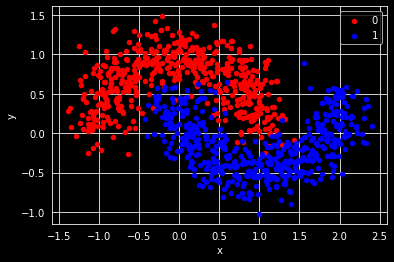

In [ ]:
N_SAMPLES = 1000
TEST_SIZE = 0.1
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_tr, X_te, y_tr_t, y_te_t = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
y_tr_t = y_tr_t.reshape(y_tr_t.shape[0],1)
y_te_t = y_te_t.reshape(y_te_t.shape[0],1)
m_tr = y_tr_t.shape[0]
m_te = y_te_t.shape[0]
y_tr = y_tr_t.T
y_te = y_te_t.T
from matplotlib import pyplot
from pandas import DataFrame
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [ ]:
def sigmoid(x):
  return (1/(1+np.exp(-x)))
def relu(x):
    return np.maximum(0,x)
def tang(x):
  return np.tanh(x)

In [ ]:
layer_dims = [X_tr.shape[1],4,6,6,5,1]
act_fn = ["relu","tang","relu","tang","sigmoid"]

In [ ]:
def initialize_parameters(layer_dims,activation_fn):
  parameters = {}
  relu_init = 2
  tang_init = 1
  for i in range(1,len(layer_dims)):
    if activation_fn[i-1] is "relu":
      initi = relu_init
    if activation_fn[i-1] is "tang":
      initi = tang_init
    parameters["W"+str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(initi/layer_dims[i-1])
    parameters["b"+str(i)] = np.random.randn(layer_dims[i],1)*0.01
  return parameters

In [ ]:
def forw_prop(X,parameters,activation_fn):
  outputs = {}
  activations = {}
  A_prev = X.T
  for i in range(1,int(len(layer_dims))-1):
    if activation_fn[i-1] is "relu":
      activ = relu
    if activation_fn[i-1] is "tang":
      activ = tang
    if activation_fn[i-1] is "sigmoid":
      activ = sigmoid
    outputs["Z" + str(i)] = np.dot(parameters["W" + str(i)],A_prev) + parameters["b"+str(i)]
    activations["A" + str(i)] = activ(outputs["Z" + str(i)])
    A_prev = activations["A" + str(i)]
  A_prev = activations["A" + str(len(layer_dims)-2)]
  if activation_fn[len(layer_dims)-2] is "relu":
    activ = relu
  if activation_fn[len(layer_dims)-2] is "tang":
    activ = tang
  if activation_fn[len(layer_dims)-2] is "sigmoid":
    activ = sigmoid
  outputs["Z" + str(len(layer_dims)-1)] = np.dot(parameters["W" + str(len(layer_dims)-1)],A_prev) + parameters["b"+str(len(layer_dims)-1)]
  activations["A" + str(len(layer_dims)-1)] = activ(outputs["Z" + str(len(layer_dims)-1)])
  activations["A0"] = X.T
  return outputs,activations

In [ ]:
def cost_func(A,y,m_ex):
  cost = ((-1/m_ex)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A))))))
  return cost

In [ ]:
def sigmoid_backward(z):
  grad_back = np.exp(-z)/np.square(1+np.exp(-z))
  return grad_back
def relu_backward(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x
def tang_backward(x):
  return (1 - np.square(np.tanh(x)))

In [ ]:
def predict(A):
  predictions = np.zeros((A.shape))
  for i in range(0,A.shape[0]):
    for j in range(0,A.shape[1]):
      if A[i,j]>0.5:
        predictions[i,j]=1
      else:
        predictions[i,j]=0
  return predictions

In [ ]:
def fit(X,Y,m_ex,num_iterations,alpha,parameters,activation_fn,print_cost,callback=None):
  costs = []
  p = 0
  for i in range(1,num_iterations+1):
    grads = {}
    outputs,activations = forw_prop(X,parameters,activation_fn)
    cost = cost_func(activations["A" + str(len(layer_dims)-1)],Y,m_ex)
    costs.append(cost)
    predictions = predict(activations["A" + str(len(layer_dims)-1)])
    if activation_fn[len(layer_dims)-2] is "relu":
      backward = relu_backward
    if activation_fn[len(layer_dims)-2] is "tang":
      backward = tang_backward
    if activation_fn[len(layer_dims)-2] is "sigmoid":
      backward = sigmoid_backward
    
    grads["dA" + str(len(layer_dims)-1)] = (1/m_ex)*(((1-Y)/(1-activations["A" + str(len(layer_dims)-1)])) - (Y/activations["A" + str(len(layer_dims)-1)]))
    grads["dZ" + str(len(layer_dims)-1)] = grads["dA" + str(len(layer_dims)-1)]*backward(outputs["Z" + str(len(layer_dims)-1)])
    grads["dW" + str(len(layer_dims)-1)] = np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)
    grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
    for j in reversed(range(1,len(layer_dims)-1)):
      if activation_fn[j-1] is "relu":
        backward = relu_backward
      if activation_fn[j-1] is "tang":
        backward = tang_backward
      if activation_fn[j-1] is "sigmoid":
        backward = sigmoid_backward
      grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
      grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
      grads["dW" + str(j)] = np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)
      grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
    for k in range(1,len(layer_dims)):
      parameters["W" + str(k)] -= (alpha*(grads["dW" + str(k)]))
      parameters["b" + str(k)] -= (alpha*(grads["db" + str(k)]))
    if print_cost is True:
      print("Cost after iteration " + str(i) + " is " + str(costs[p]) + " -------- " + "Training accuracy = " + str(float(np.mean(predictions==Y,axis=1))*100))
    p = p+1
    if(i % 50 == 0):
      if(callback is not None):
                callback(i, parameters)
  return costs, parameters


In [ ]:
def prec_rec(A,y):
  tp = 0
  fp = 0
  fn = 0
  for i in range(0,y.shape[1]):
    if ((A[0,i]==1)and(y[0,i]==1)):
      tp = tp+1
    if ((A[0,i]==1)and(y[0,i]==0)):
      fp = fp+1
    if (A[0,i]==0)and(y[0,i]==1):
      fn = fn+1
  prec = tp/(tp+fp)
  rec = tp/(tp+fn)
  f1 = (2*prec*rec)/(prec+rec)
  return prec,rec,f1

In [ ]:
def cross_val(X,y,params_tr,print_values):
  out_cv,act_cv = forw_prop(X,params_tr,act_fn)
  predictions_cv = predict(act_cv["A" + str(len(layer_dims)-1)])
  accu_cv = float(np.mean(predictions_cv==y,axis=1))*100
  prec_cv,rec_cv,f1_cv = prec_rec(predictions_cv,y)
  if print_values is True:
    print("CROSS VAL RESULTS: ")
    print("Cross val accuracy = " + str(accu_cv))
    print("Precision: " + str(prec_cv))
    print("Recall: " + str(rec_cv))
    print("F1 score: " + str(f1_cv))
    print('\n')
    print('\n')
  return accu_cv,prec_cv,rec_cv,f1_cv

In [ ]:
def test(X,y,params_tr,print_values):
  out_te,act_te = forw_prop(X,params_tr,act_fn)
  predictions_te = predict(act_te["A" + str(len(layer_dims)-1)])
  accu_te = float(np.mean(predictions_te==y,axis=1))*100
  prec_te,rec_te,f1_te = prec_rec(predictions_te,y)
  if print_values is True:
    print("TEST RESULTS: ")
    print("Testing accuracy = " + str(accu_te))
    print("Precision: " + str(prec_te))
    print("Recall: " + str(rec_te))
    print("F1 score: " + str(f1_te))
    print('\n')
    print('\n')
  return accu_te,prec_te,rec_te,f1_te

In [ ]:
parameters_dat = initialize_parameters(layer_dims,act_fn)
costs,parameters = fit(X_tr,y_tr,m_tr,10000,0.015,parameters_dat,act_fn,print_cost=True)

Streaming output truncated to the last 5000 lines.
Cost after iteration 5002 is 0.0767301117607949 -------- Training accuracy = 97.0
Cost after iteration 5003 is 0.07672766318400517 -------- Training accuracy = 97.0
Cost after iteration 5004 is 0.07672521868429168 -------- Training accuracy = 97.0
Cost after iteration 5005 is 0.07672278074059301 -------- Training accuracy = 97.0
Cost after iteration 5006 is 0.07672034523505936 -------- Training accuracy = 97.0
Cost after iteration 5007 is 0.07671791249942433 -------- Training accuracy = 97.0
Cost after iteration 5008 is 0.07671548183358261 -------- Training accuracy = 97.0
Cost after iteration 5009 is 0.07671305314692148 -------- Training accuracy = 97.0
Cost after iteration 5010 is 0.07671062637511658 -------- Training accuracy = 97.0
Cost after iteration 5011 is 0.07670820147168844 -------- Training accuracy = 97.0
Cost after iteration 5012 is 0.07670577845699778 -------- Training accuracy = 97.0
Cost after iteration 5013 is 0.076703

In [ ]:
#cross_val(X_cv,y_cv,parameters,print_values=True)
test(X_te,y_te,parameters,print_values=True)

TEST RESULTS: 
Testing accuracy = 99.0
Precision: 0.9787234042553191
Recall: 1.0
F1 score: 0.989247311827957






(99.0, 0.9787234042553191, 1.0, 0.989247311827957)

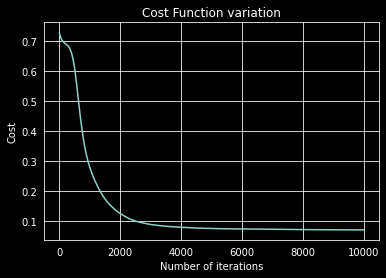

In [ ]:
import matplotlib.pyplot as plt
itera = np.arange(1,len(costs)+1,1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost Function variation')
plt.plot(itera,costs)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/moonvis_hyb"
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2,-1)
XX, YY = grid
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
import os
def callback_numpy_plot(index, params):
    plot_title = "Iteration {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    out,act = forw_prop(np.transpose(grid_2d),params,act_fn)
    prediction_probs = act["A" + str(len(layer_dims)-1)]
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_te, y_te, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [ ]:
layer_dims_vis = layer_dims
layer_dims_vis[0] = 2
parameters_dat = initialize_parameters(layer_dims_vis,act_fn)
_,params_values = fit(X_tr, y_tr, m_tr, 10000, 0.015, parameters_dat,activation_fn = act_fn,print_cost=False,callback = callback_numpy_plot)

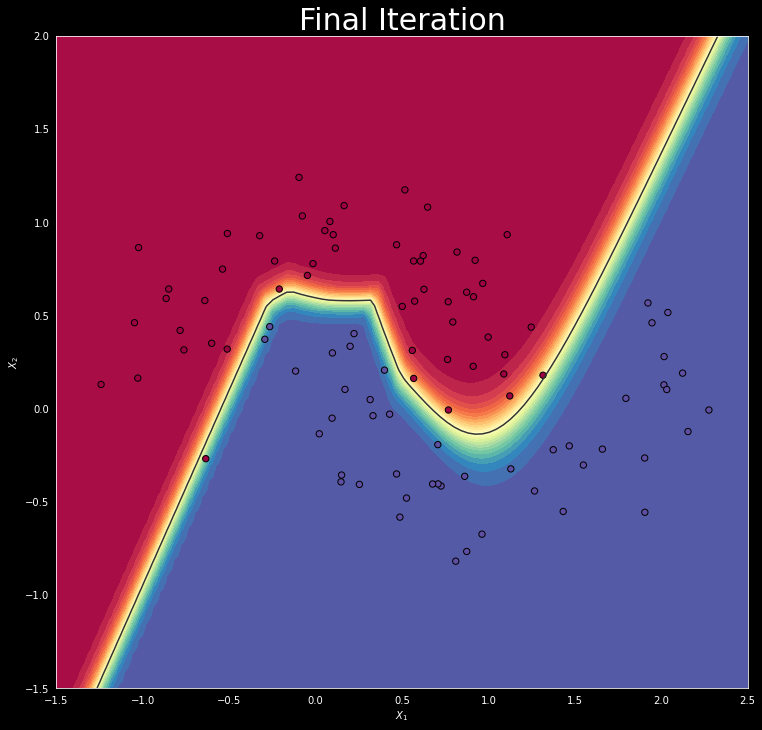

In [ ]:
out,act = forw_prop(np.transpose(grid_2d),params_values,act_fn)
prediction_probs_np = act["A" + str(len(layer_dims)-1)]
prediction_probs_np = prediction_probs_np.reshape(prediction_probs_np.shape[1], 1)
make_plot(X_te, y_te, "Final Iteration", file_name=None, XX=XX, YY=YY, preds=prediction_probs_np, dark=True)